In [1]:
import tess_cpm
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
import lightkurve as lk

In [2]:
plt.rcParams["figure.figsize"] = (12, 8)

In [3]:
f = "exoplanets/tess-s0010-1-1_173.957400_-29.156000_100x100_astrocut.fits"
f2 = "exoplanets/tess-s0001-1-4_316.631902_-26.692632_64x64_astrocut.fits"

In [4]:
exo = tess_cpm.Source(f)

Removing 154 bad data points (out of 1211) using the TESS provided QUALITY array


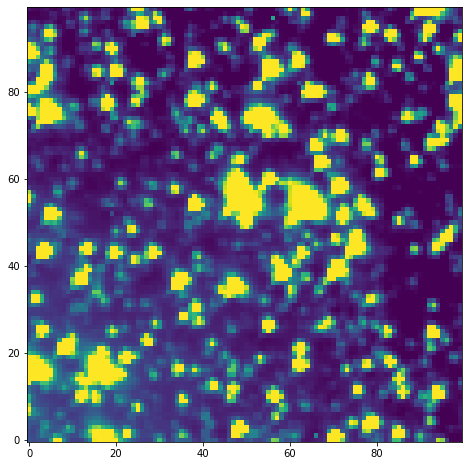

In [5]:
exo.plot_cutout();

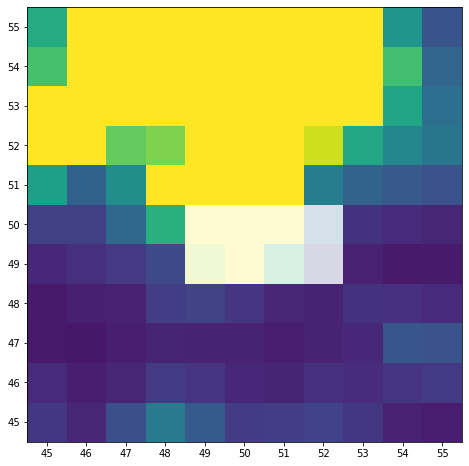

In [8]:
exo.set_aperture(rowlims=[49, 50], collims=[49, 52])
exo.plot_cutout(rowlims=[45, 55], collims=[45, 55], show_aperture=True);

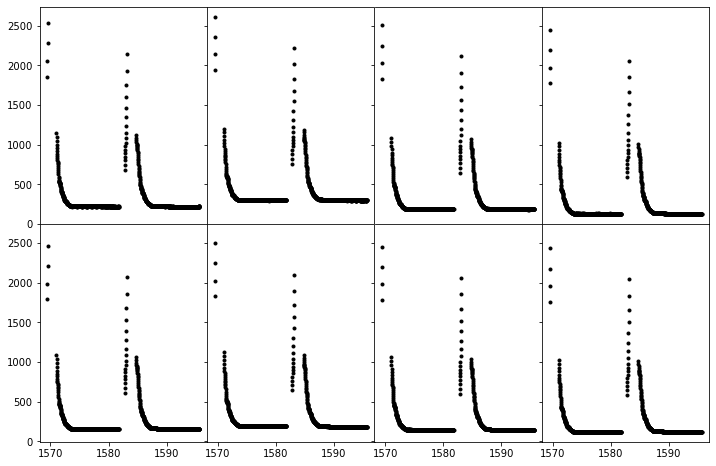

In [9]:
exo.plot_pix_by_pix();

In [10]:
exo.add_cpm_model()
exo.set_regs([0.1])
exo.holdout_fit_predict(k=10);

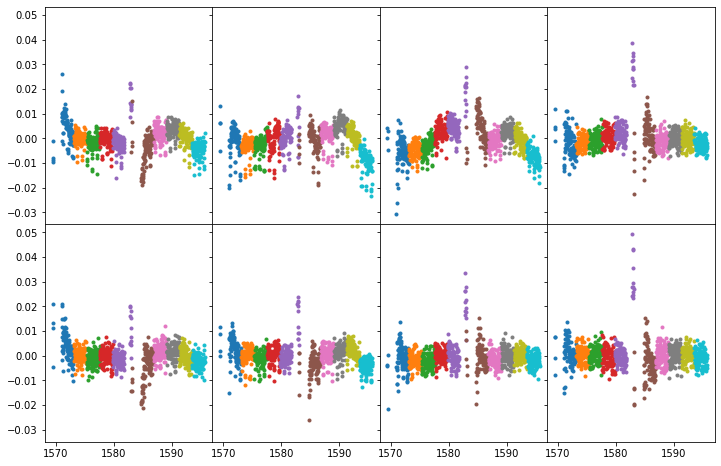

Summing over 2 x 4 pixel lightcurves


In [11]:
# exo.plot_pix_by_pix(split=True, data_type="raw")
# exo.plot_pix_by_pix(split=True, data_type="prediction")
# exo.plot_pix_by_pix(split=True, data_type="cpm_prediction")
# exo.plot_pix_by_pix(split=True, data_type="poly_model_prediction")
exo.plot_pix_by_pix(split=True, data_type="cpm_subtracted_flux")
lc = exo.get_aperture_lc("cpm_subtracted_flux")

In [12]:
# lc.shape
outliers = exo.get_outliers(window=10, sigma_upper=5, sigma_lower=0.8)

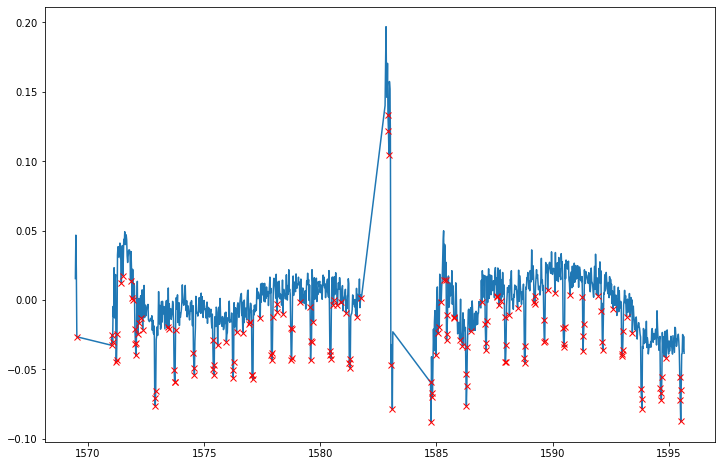

In [13]:
plt.plot(exo.time, lc)
plt.plot(exo.time[outliers], lc[outliers], "x", c="red")
# plt.plot(exo.time[~outliers], lc[~outliers], "-", c="C2")

Using user-provided mask. Clipping 164 points.


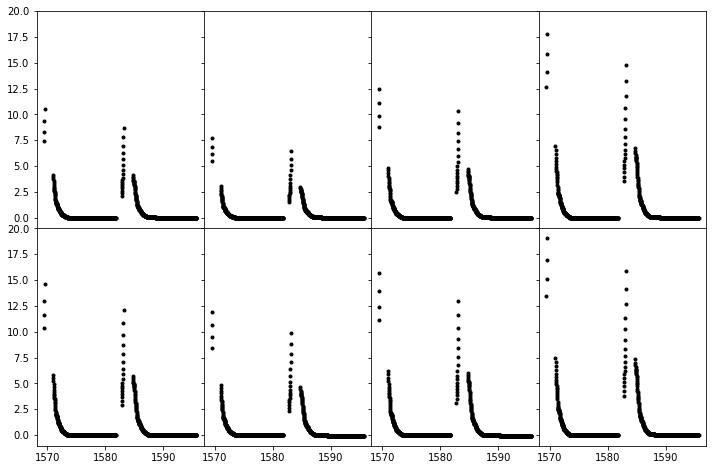

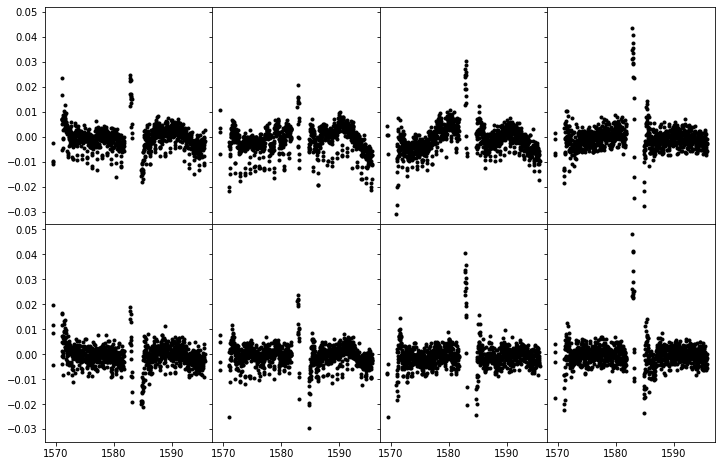

In [14]:
exo.holdout_fit_predict(k=50, mask=~outliers);
exo.plot_pix_by_pix("cpm_prediction");
exo.plot_pix_by_pix("cpm_subtracted_flux");

Summing over 2 x 4 pixel lightcurves


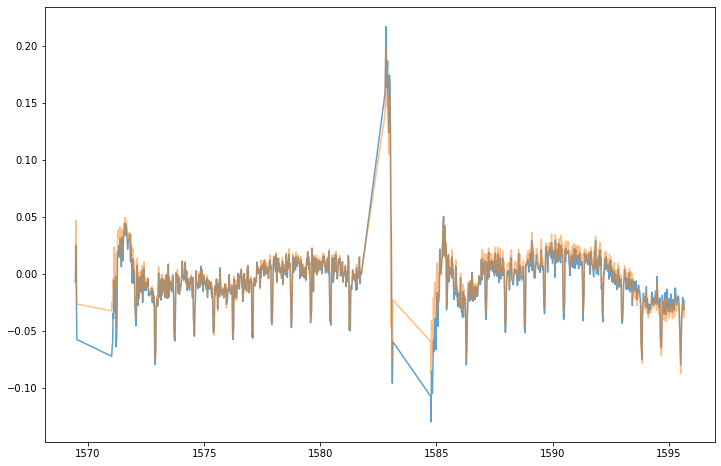

In [18]:
masked_lc = exo.get_aperture_lc("cpm_subtracted_flux")
# plt.plot(exo.time, lc)
plt.plot(exo.time, masked_lc, alpha=0.7)
plt.plot(exo.time, lc, alpha=0.5,)

In [ ]:
apt_cpm = exo.get_aperture_lc(data_type="cpm_prediction")
apt_lc = exo.get_aperture_lc(data_type="rescaled_cpm_subtracted_flux")
# exo.get_aperture_lc(split=False, data_type="cpm_subtracted_lc")

In [ ]:
# plt.plot(exo.time, apt_cpm, ".")
plt.plot(exo.time, apt_lc, ".")
# outliers = np.abs(apt_lc) > 1.5*np.std(apt_lc)
# print(np.sum(outliers))
# plt.plot(exo.time[outliers], apt_lc[outliers], "x", c="k")
# plt.plot(exo.time[~outliers], apt_lc[~outliers], "x", c="k")

# apt_lc[pre_clip] = np.nan
# clip = np.abs(apt_lc) > 1*np.std(apt_lc[pre_clip])
# plt.plot(exo.time[clip], apt_lc[clip], "x", c="r")
# np.any(clip)

In [ ]:
cpm_regs = 10.0 ** np.arange(-10, 10)

In [ ]:
min_cpm_reg, cdpps = exo.calc_min_cpm_reg(cpm_regs, k=10)
plt.savefig("Exoplanet_CDPPS.png", dpi=200)

In [ ]:
cpm_regs

In [ ]:
print(min_cpm_reg)
exo.set_regs([min_cpm_reg])
exo.holdout_fit_predict(k=10);
flux_splits = exo.get_aperture_lc(data_type="raw", split=True)
splits = exo.get_aperture_lc(data_type="cpm_subtracted_flux", split=True)
f, axs = plt.subplots(2, 1, sharex=True, figsize=(18, 8))
for time, split, f_split in zip(exo.split_times, splits, flux_splits):
    axs[0].plot(time, f_split, ".")
    axs[0].set_ylabel("Original Flux", fontsize=15)
    axs[1].plot(time, split)
    axs[1].set_ylabel("Detrended Flux", fontsize=15)
    axs[1].set_xlabel( "Time [BTJD]", fontsize=15)
plt.savefig("Exoplanet_LC.png", dpi=200)

In [ ]:
print(min_cpm_reg)
exo.set_regs([min_cpm_reg])
exo.holdout_fit_predict(k=10);
flux_splits = exo.get_aperture_lc(data_type="raw", split=True)
splits = exo.get_aperture_lc(data_type="cpm_subtracted_flux", split=True)
f, axs = plt.subplots(2, 1, sharex=True, figsize=(18, 8))
for time, split, f_split in zip(exo.split_times, splits, flux_splits):
    axs[0].plot(time, f_split, ".")
    axs[0].set_ylabel("Original Flux", fontsize=15)
    axs[1].plot(time, split)
    axs[1].set_ylabel("Detrended Flux", fontsize=15)
    axs[1].set_xlabel( "Time [BTJD]", fontsize=15)
# plt.savefig("Exoplanet_LC.png", dpi=200)

In [ ]:
lc = lk.TessLightCurve(time=exo.time[~outliers], flux=apt_lc[~outliers])
# lc.plot(normalize=False)
# lc.normalize()
# np.nanmedian(lc.flux)
# np.nanstd(lc.flux)
# np.abs(np.nanmedian(lc.flux)) < 0.5*np.nanstd(lc.flux)
lc.plot()
lc.estimate_cdpp()
# a = lc.flatten()
# a

In [ ]:
split_cpm_subtracted_lc = exo.get_aperture_lc(split=True, data_type="cpm_subtracted_lc")
cpm_subtracted_lc = exo.get_aperture_lc(data_type="cpm_subtracted_lc")

for t, l in zip(exo.split_times, split_cpm_subtracted_lc):
    plt.plot(t, l)

Removing 15 bad data points (out of 1282) using the TESS provided QUALITY array


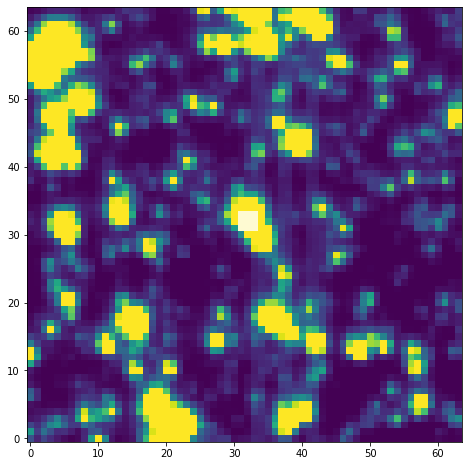

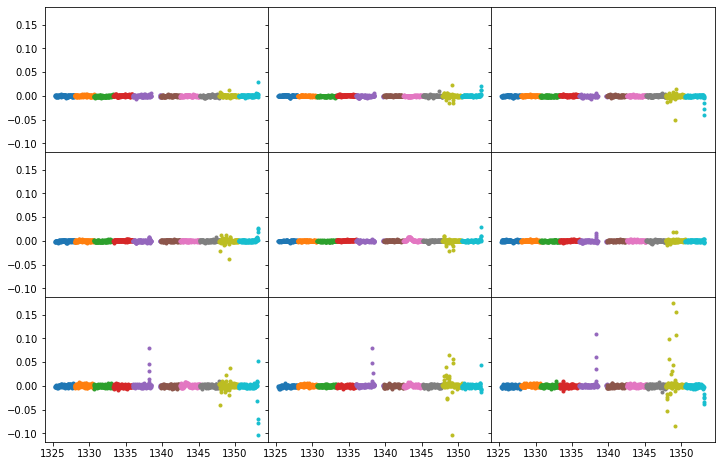

Summing over 3 x 3 pixel lightcurves


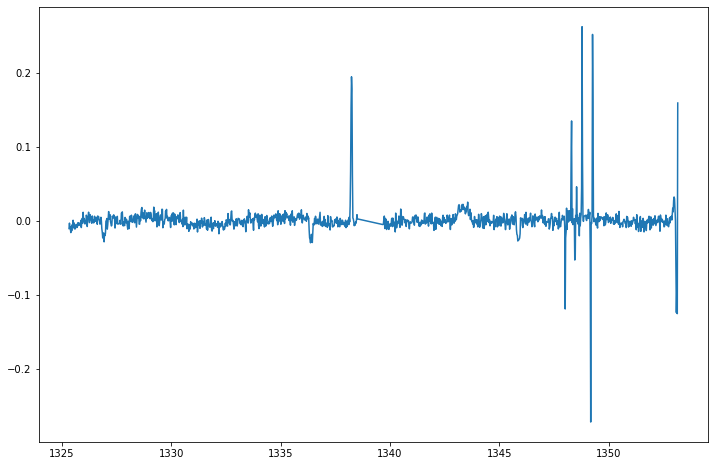

In [25]:
# TIC 29857954
tic = tess_cpm.Source(f2, remove_bad=True)
tic.set_aperture(rowlims=[28, 36], collims=[28, 36])  # full aperture
tic.set_aperture(rowlims=[28, 36], collims=[28, 36])  # full aperture
tic.set_aperture(rowlims=[31, 33], collims=[31, 33])  # not full aperture


tic.plot_cutout(show_aperture=True);
tic.add_cpm_model()
# tic.add_poly_model()
tic.set_regs([0.001])
tic.holdout_fit_predict(k=10);
tic.plot_pix_by_pix("cpm_subtracted_flux", split=True);
tic_lc = tic.get_aperture_lc("cpm_subtracted_flux")
plt.plot(tic.time, tic_lc)

# There's already one known asteroid crossing in the aperture for this source around 1338.
# Is there another one around the top left corner at 1347?

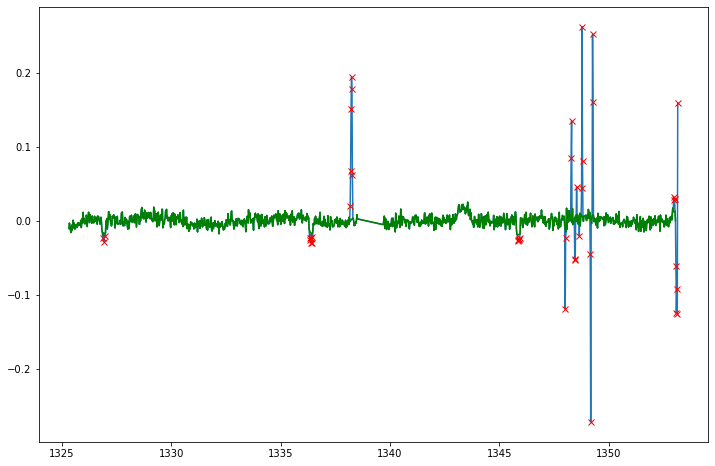

In [28]:
tic_lc.shape

outliers = tic.get_outliers(sigma_upper=1, sigma_lower=1)
plt.plot(tic.time, tic_lc)
# s = (tic.time > 1347) * (tic.time < 1350) + (tic.time > 1353)
# 338<Time<1339 and 1346.8<Time<1348.6
# s = ((tic.time > 1338) * (tic.time < 1339)) + ((tic.time > 1346.8) * (tic.time < 1348.6))
# asteroid = ((tic.time > 1338)) * (tic.time < 1339)
# outliers[asteroid] = True
plt.plot(tic.time[outliers], tic_lc[outliers], "x", c="red")
plt.plot(tic.time[~outliers], tic_lc[~outliers], c="green")

Using user-provided mask. Clipping 43 points.
Summing over 3 x 3 pixel lightcurves


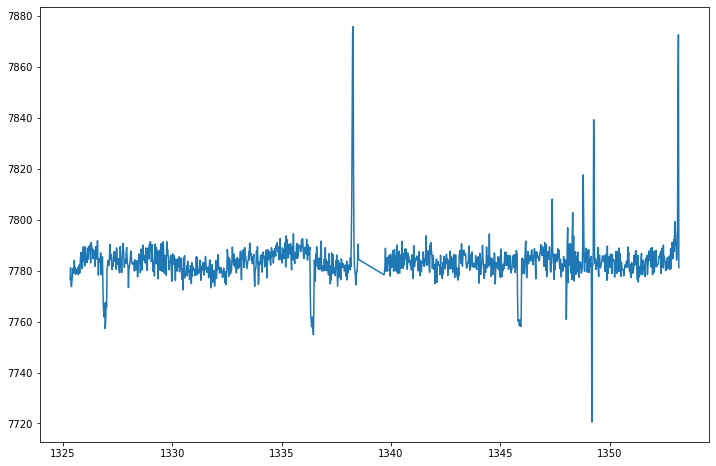

In [29]:
tic.holdout_fit_predict(k=50, mask=~outliers);
# tic.plot_pix_by_pix("rescaled_cpm_subtracted_flux", split=True)

tic_lc = tic.get_aperture_lc("rescaled_cpm_subtracted_flux")
# plt.plot(tic.time[~s], tic_lc[~s])
plt.plot(tic.time, tic_lc)

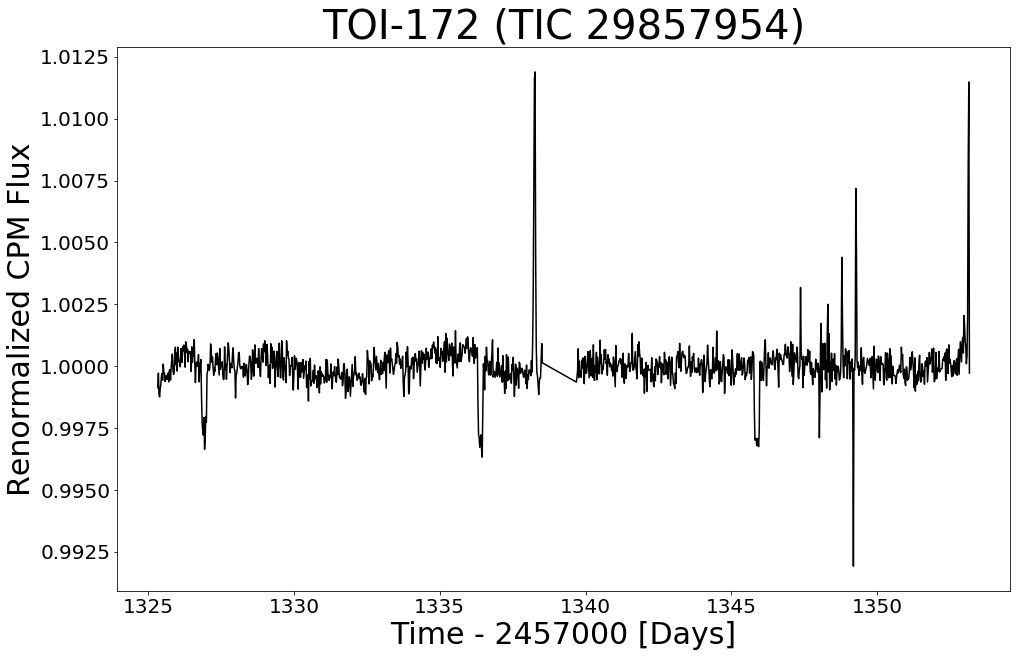

In [30]:
plt.figure(figsize=(16, 10))

plt.plot(tic.time, tic_lc / np.nanmedian(tic_lc), c="k")
plt.xlabel("Time - 2457000 [Days]", fontsize=30)
plt.ylabel("Renormalized CPM Flux", fontsize=30)
plt.title("TOI-172 (TIC 29857954)", y=1, fontsize=40)
plt.tick_params(labelsize=20)
# plt.savefig("TOI172.png", dpi=300)

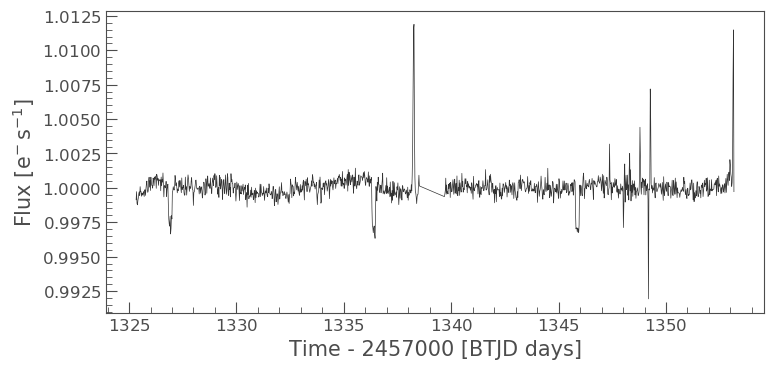

In [32]:
lc = lk.TessLightCurve(time=tic.time, flux=tic_lc / np.nanmedian(tic_lc))
lc.plot()

In [33]:
lc.to_csv("/home/soichiro/code/tessninja3/cpm_lc.csv")

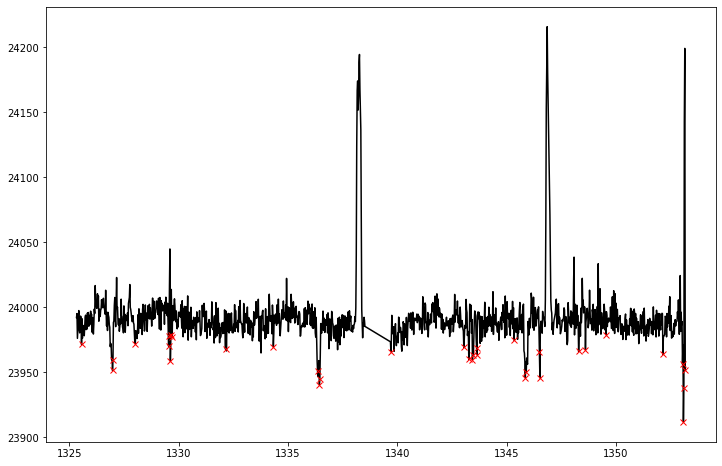

In [19]:
transits = tic.get_outliers(sigma_lower=0.7, sigma_upper=10, window=40)
# tic.get_outliers?
plt.plot(tic.time, tic_lc, "k")
plt.plot(tic.time[transits], tic_lc[transits], "x", c="r")

In [ ]:
# plt.plot(tic.time, tic_lc+1)

In [ ]:
# lc = lk.TessLightCurve(time=tic.time[~s], flux=(tic_lc)[~s] / np.nanmedian(tic_lc[~s]))
lc = lk.TessLightCurve(time=tic.time[~asteroid], flux=(tic_lc[~asteroid] / np.nanmedian(tic_lc[~asteroid])))

# lc = lk.TessLightCurve(time=tic.time[~outliers], flux=(tic_lc+1)[~outliers])

In [ ]:
lc.plot()
cleaned_lc = lc.remove_outliers(sigma=5)
cleaned_lc.plot()

In [ ]:
cleaned_lc.estimate_cdpp(transit_duration=2)

In [ ]:
f_lc = lc.flatten()

In [ ]:
f_lc.plot()

In [ ]:
f_lc.estimate_cdpp(transit_duration=2)